# RL homework 3

-------------------------------


**Name:** Guoqing Pan

**SN:** 19075457

-----------------------------------


**Due date:** *May 13, 2020, 11:00 am*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will implement several algorithms to investigate the role of planning in reinforcement learning.

#### Part 2:
You will be guided through the implementation of a full deep reinforcement learning agent.

#### Part 3:
You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.



# Setup

Run all the cells in this section, but do not modify them.

## Imports

In [6]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [27]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


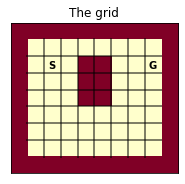


An alternative grid world


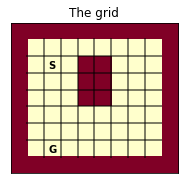


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


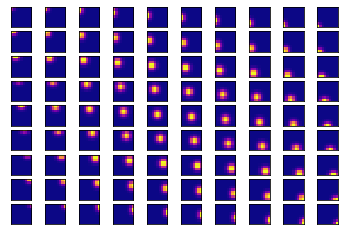

In [29]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [30]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Planning [50 marks]

## 1.1: Implement Models

### Question 1.1.1
**[3 pts]** 

Implement a trainable **tabular model** of the environment.

The model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

Given that the environment is deterministic and tabular the model will reduce to a simple lookup table.

In [43]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.number_of_states = number_of_states
    self.number_of_actions = number_of_actions
#     self.sa = np.zeros((number_of_states,number_of_actions,number_of_states)) 
    self.sa = np.zeros((number_of_states,number_of_actions),dtype='int8') 

    self.r = np.zeros((number_of_states, number_of_actions),dtype='float32')
    self.d = np.zeros((number_of_states, number_of_actions),dtype='float32')

  def next_state(self, s, a):

    return self.sa[s, a]
  
  def reward(self, s, a):

    return self.r[s, a]

  def discount(self, s, a):
    return self.d[s, a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.r[state,action] = reward
    self.d[state,action] = discount
    self.sa[state,action] = next_state

### Question 1.1.2

**[5 pts]** 

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by stochastic gradient descent. 

Write down the update to the parameters of the models and implement the update in the model below.


In [78]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.number_of_features = number_of_features
    self.number_of_actions = number_of_actions
    self.M_s = np.zeros((number_of_actions,number_of_features,number_of_features),dtype='float32')
    self.m_r = np.zeros((number_of_actions,number_of_features),dtype='float32')
    self.m_g = np.zeros((number_of_actions,number_of_features),dtype='float32')
    
  def next_state(self, s, a):

    return np.dot(self.M_s, s)[a]
  
  def reward(self, s, a):
    return np.dot(self.m_r, s)[a]

  def discount(self, s, a):
    return np.dot(self.m_g, s)[a]

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
        
    s_p = np.dot(self.M_s[action], state).reshape((self.number_of_features,1))
    r_p = np.dot(self.m_r[action], state)
    g_p = np.dot(self.m_g[action], state)

    self.M_s[action] += step_size * np.dot((next_state.reshape((self.number_of_features,1)) - s_p),state.reshape((1,self.number_of_features)))
    self.m_r[action] += step_size * (reward - r_p) * state
    self.m_g[action] += step_size * (discount - g_p) * state
    
    
    

## 1.2: Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents you implement in this section must share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode of the agent's lifetime.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Question 1.2.1

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate each observed transition *(s, a, r, s')* in a *replay buffer*,
* apply an online Q-learning update with the most recently observed transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [46]:
import random

In [47]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.number_of_states = number_of_states
    self.number_of_actions = number_of_actions
    self._state = initial_state
    self._action = 0
    self.behaviour_policy = behaviour_policy
    self.num_offline_updates = num_offline_updates
    self._step_size = step_size
    self.buffer = []
    self.value = np.zeros((number_of_states, number_of_actions),dtype='float32')
    
  @property
  def q_values(self):
    return self.value

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append([s,a,r,g,next_s])
    self.value[s,a] += self._step_size * (r + g * np.max(self.value[next_s]) - self.value[s,a])
    
    for _ in range(self.num_offline_updates):
        sample_s, sample_a, sample_r, sample_g, sample_next_s = random.sample(self.buffer,1)[0]
        self.value[sample_s, sample_a] += self._step_size * (sample_r + sample_g * np.max(self.value[sample_next_s]) - self.value[sample_s, sample_a])
    self._action = self.behaviour_policy(self.value[next_s])
    self._state = next_state
    return self._action


### Question 1.2.2

**[5 pts]**

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [48]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.number_of_states = number_of_states
    self.number_of_actions = number_of_actions
    self.num_offline_updates = num_offline_updates
    self._state = initial_state
    self.behaviour_policy = behaviour_policy
    self._step_size = step_size
    self._action = 0
    

    self.buffer = []
    self.value = np.zeros((number_of_states, number_of_actions))
    self.model = TabularModel(number_of_states, number_of_actions)


  @property
  def q_values(self):
    return self.value

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append([s, a, r, g, next_s])

#     model-free
    self.value[s,a] += self._step_size * (r + g * np.max(self.value[next_s]) - self.value[s,a])
    
#     model update
    self.model.update(s, a, r, g, next_s)

#     model-based planning
    for _ in range(self.num_offline_updates):
        sample_s, sample_a, _, _, _ = random.sample(self.buffer,1)[0]
        sample_r, sample_g, sample_next_s = self.model.transition(sample_s, sample_a)
        self.value[sample_s, sample_a] += self._step_size * (sample_r + sample_g * np.max(self.value[sample_next_s]) - self.value[sample_s, sample_a])
    self._action = self.behaviour_policy(self.value[next_s])
    self._state = next_state
    return self._action



### Question 1.2.3

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.  The observed `state` will now be a vector of length `number_of_features`, and the value estimate will be $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [49]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self.v = np.zeros((number_of_actions,number_of_features),dtype='float32')
    
    
    
  def q(self, state):
    return np.matmul(self.v,state)
    

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    self.v[a,:] += self._step_size * (r + g*np.max(np.dot(self.v, next_s)) - np.dot(self.v,s)[a]) * s
    self.buffer.append([s, a, r, g, next_s])

    for _ in range(self.num_offline_updates):
        sample_s, sample_a, sample_r, sample_g, sample_next_s = random.sample(self.buffer,1)[0]
        self.v[sample_a,:] += self._step_size * (sample_r + sample_g*np.max(np.dot(self.v, sample_next_s)) - np.dot(self.v,sample_s)[sample_a]) * sample_s
    
    self._state = next_s
    self._action = self.behaviour_policy(np.dot(self.v, next_s))
    return self._action
    

### Question 1.2.4

**[5 pts]**

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [50]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self.v = np.zeros((number_of_actions,number_of_features),dtype='float32')
    self.model = LinearModel(number_of_features, number_of_actions)

    
  def q(self, state):
    return np.dot(self.v,state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
#     model update
    self.model.update(s, a, r, g, next_s)
    
#     model-free 
    self.v[a,:] += self._step_size * (r + g*np.max(np.dot(self.v, next_s)) - np.dot(self.v,s)[a]) * s
    self.buffer.append([s, a, r, g, next_s])
    for _ in range(self.num_offline_updates):
        sample_s, sample_a, _, _, _ = random.sample(self.buffer,1)[0]
        sample_r, sample_g, sample_next_s = self.model.transition(sample_s,sample_a)
        self.v[sample_a,:] += self._step_size * (sample_r + sample_g*np.max(np.dot(self.v, sample_next_s)) - np.dot(self.v,sample_s)[sample_a]) * sample_s
    
    self._state = next_s
    self._action = self.behaviour_policy(np.dot(self.v, next_s))
    return self._action


## 1.3: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

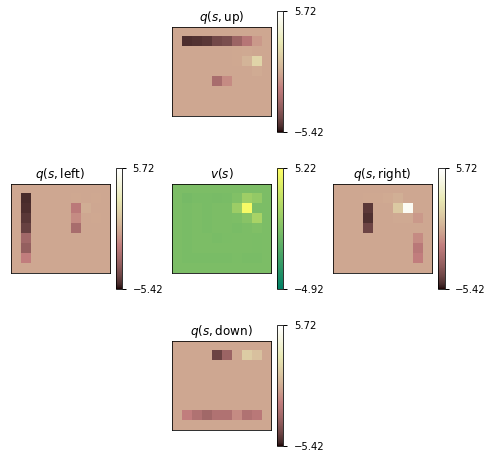

In [13]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

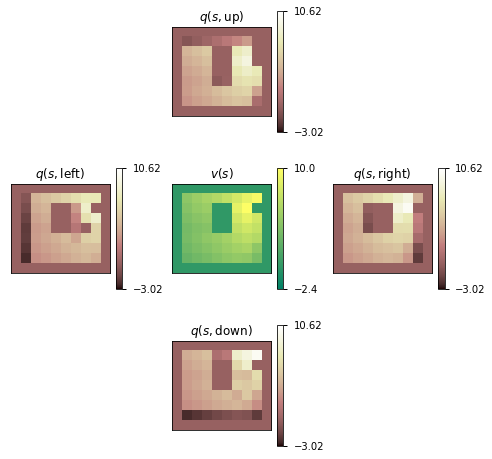

In [90]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

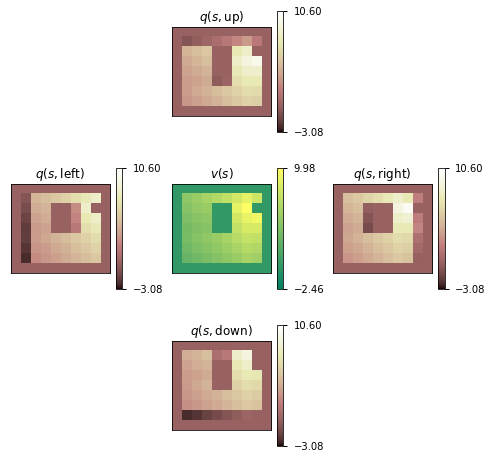

In [24]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 1.3.1

**[3 pts]**

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

> *The data efficiency and value estimate performance ranking for these 3 algortighms is: Dyna Q = ExperienceReplay > online Q-learning. In 2000 steps in environment, DynaQ and ExperienceReplay could learn the value estimate for most of states or (states, action) pairs, while online Q-learning learn only several values estimate. It is obvious that online learning needs more steps in environment to achieve similar performance as other two.*

> *Because the 30 steps off-lines updates, ExperienceReplay and Dyna have 60000 more times of update on value estimate and could make fuller use of the 2000 steps of experience from interaction with environment than online Qlearning.*


### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

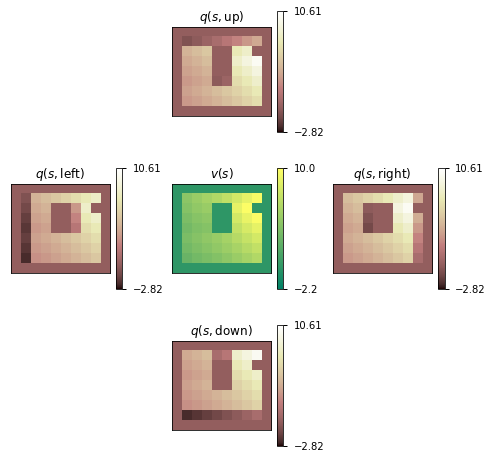

In [35]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

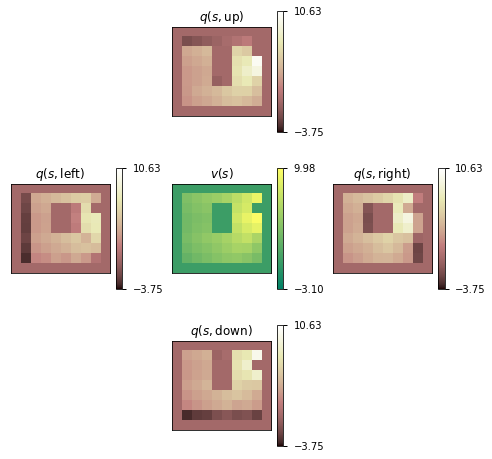

In [28]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

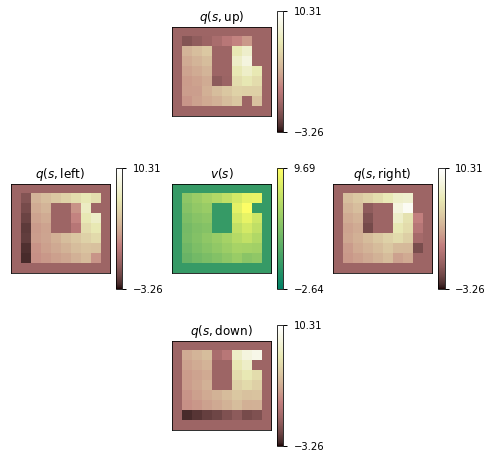

In [29]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above are the same as those above question 1.3.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

### Question 1.3.2

**[3 pts]**

How do the learnt values, and the relative performances, change, compared to the experiment above question 1.3.1?  Explain in at most 5 sentences.

> *With same number of updates, the performance ranking becomes Online Q-leanring > DynaQ = ExperienceReplay. For online Q-learning, the data of 6200 steps are purely from environment which is far more diversed than the data in the other two algorithms. The data for DynaQ and ExperienceReplay compose of 2000 steps from environment and 6000 steps sample from these 2000 real steps which give less information (on combination of (s_t, a_t, g_t, r_{t+1}, s_{t+1}) ) for value estimate updates than 6200 real steps from environment.*

> *Furthermore, to learn a model of environment and then updates value based on the model cost extra computation, compared to direct learning values from environment.*

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

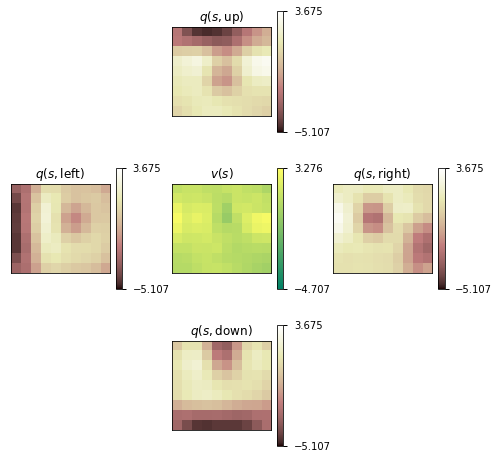

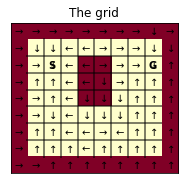

In [87]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])

plot_action_values(q)
plot_greedy_policy(grid, q)

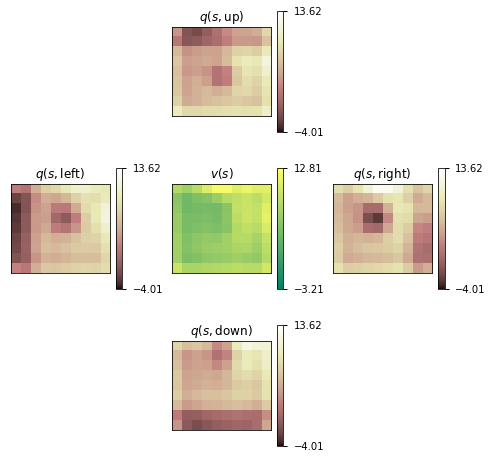

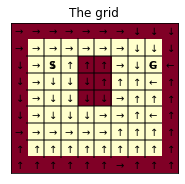

In [82]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

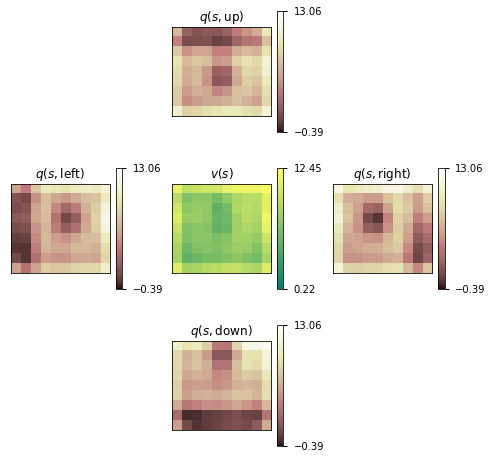

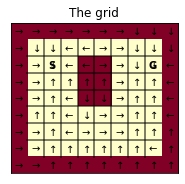

In [91]:
# DynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Question 1.3.3

**[3 pts]**

How do the value estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 2.2.1?

Explain the results in at most 5 sentences.

> *Function approximation has the advangtage of generalization on value of unseen states. Here, the states are represented as feature vectors and linear approximations to give state and action values are learnt. The wall and goal states have never be seen in learning and in tabular setting the value in these states left as zero. However, while experience just a subset of whole grid space, function approximation could generate a well approximation over a larger grid space than tabular setting, including goal and wall states. *

### Question 1.3.4

**[3 pts]**

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

> *Still a bit away from optimal policy and could be hesitant about the route. For example, they may be stuck at the start location or hesitate to go into the goal.*

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

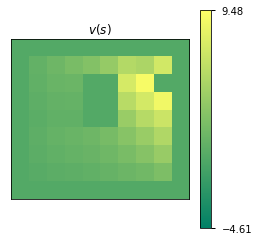

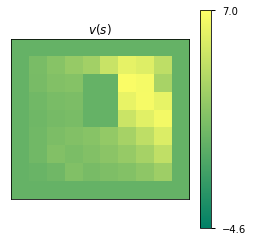

In [30]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)
# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps/30 ))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

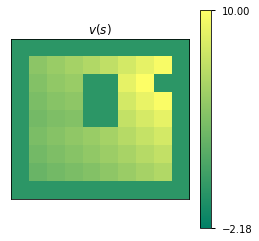

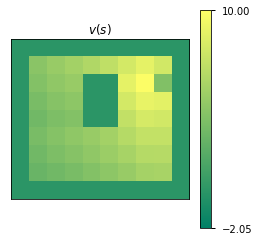

In [34]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)
# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps /30 ))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

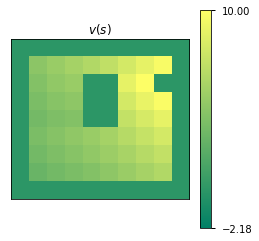

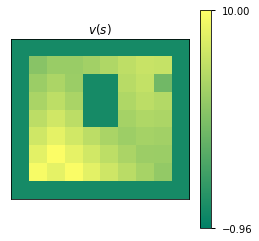

In [0]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Question 1.3.5

**[5 pts]**

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> *DynaQ performs better than online Q-learning in value estimates after the changepoint. After the changepoint, online Q-learning updates the state values for 666 times, while DynaQ 666 * (30+1) = 20646 times. Once DynaQ recieve the different rewards around orgianl(new) goal location, it directly update the tabular model, i.e. q values for these (states, action) pairs around orgianl(new) goal locations. Once model is updated, in offline update, DynaQ could update state value towards the new setting 30 more times with updated model, than online Q-leanring.*

### Question 1.3.6

**[5 pts]**

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location, explain what you see.

> *ExperienceReplay works worse. After the 20000 pretrained step, both DynaQ and ExperienceReplay have learned the shorter way to visit old goal location without wandering around. Even after the changepoint, they will first hit the old goal and update its value which haven't been update in pretrain. Once the offline updates sample the data related to the new goal, DynaQ directly replace the old values with new value while in ExperienceReplay new value is added to the buffer. The proportion of new values is small in buffer because of the 20000 pretrained steps. DynaQ could offline update values with new setting while Experience Replay may still updates with the mixture of new and old records.*


# Part 2: Deep RL [25 marks]

### Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [0]:
!git clone https://github.com/deepmind/bsuite.git
!pip install --upgrade pip setuptools
!pip install bsuite/
!pip install dm-haiku
# !pip install --upgrade jaxlib

Cloning into 'bsuite'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (878/878), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 1362 (delta 628), reused 683 (delta 462), pack-reused 484
Receiving objects: 100% (1362/1362), 681.06 KiB | 972.00 KiB/s, done.
Resolving deltas: 100% (949/949), done.
     |████████████████████████████████| 1.5MB 2.6MB/s 
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Processing ./bsuite
     |████████████████████████████████| 294 kB 4.0 MB/s 
  Created wheel for bsuite: filename=bsuite-0.0.0-py3-none-any.whl size=245994 sha256=a0775dc195a56c6e8fa6c2c74ed8b9cfbed243c039b4f5ee7f810ebb3be4ef04
  Stored in directory: /tmp/pip-ephem-wheel-cache-9el9ancj/wheels/7f/28/67/e4427835abaace36e6b213a4f3879d9e28807addff21d62df5
  Created wheel for frozendict: filena

In [0]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp
from jax.experimental import optix 
import haiku as hk

import matplotlib.pyplot as plt
from collections import defaultdict


### Neural networks

You will now use JAX to define a network parametrising:

* The values of each state $v_{\pi}(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions (`init_net`, and `apply_net`):

The `init` function has signature `parameters = init_net(key, obs)`. 
  * takes a `jax.random.PRNGKey` and an `observation`
  * returns randomly sampled weights for the neural network.

The `apply_net` functions have signature `v, p = apply_net(parameters, obs)` 
  * takes the current set of `parameters` and an `observation`
  * returns a scalar value `v` and a vector of preferences `p`

### Q 3.1 [5 marks]

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = Relu(W.dot(flat_obs) + b)`
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden layer should have 50 units
* the action preferences should be a vector of 3 elements (one per each available action),
* the value should be a scalar (not a vector with one element).


In [0]:
def forward_pass(obs):
    flatten_fn = lambda x: jnp.reshape(x, (-1,))
    h = hk.Sequential([flatten_fn, hk.Linear(50)])(obs)
    pref = hk.Sequential([jax.nn.relu,hk.Linear(3)])(h)
    value = hk.Sequential([jax.nn.relu,hk.Linear(1)])(h)


    return value, pref



init_net, apply_net = hk.transform(forward_pass)

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q 3.2 [5 marks]

Implement a softmax policy parametrised by the neural network above.

The function has signature `action = policy(net_params, key, obs)`,
* Taking the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Returning an `action` sampled from a softmax distribution (with temperature 1.) over the set of preferences output by the neural network.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you will therefore need to use the `split` function to generate a new random key before every new sampling. The run loop that runs the experiment later on takes care of this for you: you can assume that a new random `key` is provided to you on each call to the `policy`, and you do not need to split the key yourself within the function.



In [0]:
@jax.jit
# """Sample action from a softmax policy."""
def policy(net_params, key, obs):
    v, p = apply_net(net_params, obs)
    p = p - jnp.max(p)
    pi = jax.nn.softmax(p)
    action = jax.random.categorical(key, logits = pi, axis = -1,shape=None)

    return action

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q 3.3 [5 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

The function must have signature `grads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `grads` has the same structure as `net_params`
  * as it contains an estimate of the gradient of the expected episodic return wrt to each parameter 

In [0]:
def policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):

    def g(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
        v_tm1, p_tm1 = apply_net(net_params, obs_tm1)
        v_t, p_t = apply_net(net_params, obs_t)
        pi_tm1 = jax.nn.log_softmax(p_tm1)[a_tm1]

        target_tm1 = r_t + discount_t * v_t[0]
        td = jax.lax.stop_gradient(target_tm1)  -  v_tm1[0]
        return pi_tm1 * td



    return jax.grad(g)(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    


### Q 3.4 [5 marks]

Implement a function to compute a stochastic estimate of the negative gradient of the value loss:   $ L(\theta) = E_{s \sim \pi}[(v_{\theta}(s) - v_{\pi}(s))^2]$

As for the policy gradient, this must be computed from a 1 step transition in the environment, so using bootstrapping after one step.

It must have signature `neg_grads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `neg_grads` has the same structure as `net_params`
  * as it contains a stochastic estimate of the negative gradient of the expected value prediction loss 

In [0]:
def neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):

    def loss(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
        v_tm1, _ = apply_net(net_params, obs_tm1)
        v_t, _ = apply_net(net_params, obs_t)
        target_tm1 = r_t + discount_t * v_t[0]
        td = jax.lax.stop_gradient(target_tm1)  -  v_tm1[0]
        return - (td ** 2)
    

    return jax.grad(loss)(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The negative gradient of the value loss identifies the direction of change in the parameters that most steeply improves the value predictions.

However, note that the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we will simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.

In [0]:
@jax.jit
def compute_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are typically rescaled to avoid taking too large a step on a single update.
For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by, rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$


### Q 3.5 [5 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
* See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for references.

This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \eta) g + \eta \mu$ where $g$ is the latest stochastic gradient.
* Update the second moment of each gradient component $\nu_i = (1 - \eta) g_i ^ 2 + \eta \nu_i $ where $g$ is the latest gradient update.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_2 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

In the next cell define a pair of functions (`opt_init`, and `opt_update`), where:

The `opt_init` function has signature `state = opt_init(params)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, state = opt_update(grads, state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

Set the algorrithm's hyper-parameters to:
* $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=1e-8$.

In [0]:
# opt_init, opt_update = ..., ...
beta1 = 0.9
beta2 = 0.999
e = 1e-8
alpha = 0.009

def opt_init(params):
    t = 0
    m = jax.tree_util.tree_map(lambda x: 0*x, params)
    v = jax.tree_util.tree_map(lambda x: 0*x, params)
    state = [t, m ,v]
    return state

def opt_update(grads, state):
    t, m , v = state
    t += 1
    m = jax.tree_multimap(lambda x,y: beta1*x + (1-beta1)*y, m, grads)
    v = jax.tree_multimap(lambda x,y: beta2*x + (1-beta2)*(y**2), v, grads)
    
    _m = jax.tree_util.tree_map(lambda x: x/ (1-beta1**t), m)
    _v = jax.tree_util.tree_map(lambda x: x/ (1-beta2**t), v)
    delta = jax.tree_multimap(lambda x,y: alpha*x/( e + y**0.5), _m, _v)
    state = [t, m, v]
    return delta, state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on seubsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

In [0]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = hk.PRNGSequence(jax.random.PRNGKey(42))
sample_input = env.observation_spec().generate_value()
net_params = init_net(next(rng), sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(optix.apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for i in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  a_tm1 = policy(net_params, next(rng), obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    a_t = policy(net_params, next(rng), new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    dJ_dtheta = compute_gradient(
        net_params, obs_tm1, a_tm1, r_t, discount_t, new_timestep.observation)

    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t


  # Experiment results tracking.
  all_episode_returns.append(episode_return)

Training agent for 1500 episodes...


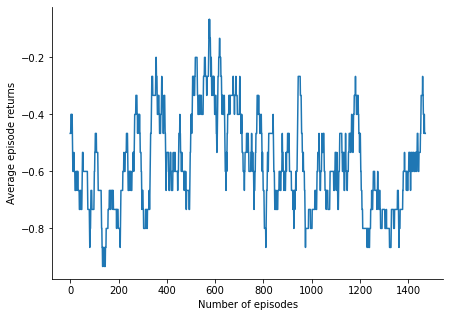

In [0]:
plt.figure(figsize=(7, 5))
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smoothed_returns = moving_average(all_episode_returns, 30)
plt.plot(smoothed_returns)

plt.ylabel('Average episode returns')
plt.xlabel('Number of episodes')

ax = plt.gca()
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Part 3: Off-policy multi-step learning [25 marks]

For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necesary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [7]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 4.1 [15 marks]
Implement the return functions below and run the cells below that.

In [22]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
#   """
#   Compute off-policy return with full importance-sampling corrections, so that
#   the return G_t is corrected with the full importance-sampling correction of
#   the rest of the trajectory.
#   """

    T = len(rewards)  # number of transitions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G = np.zeros((T,))
    ro = np.zeros((T,))
    for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
        if t == T - 1:
          G[t] = r[t] + d[t]*v[t + 1]
          ro[t] = pi[t] / mu[t]
        else:
          G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
          ro[t] = ro[t+1] * pi[t] / mu[t]
    return G*ro


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
#   """
#   Compute off-policy return with per-decision importance-sampling corrections.
#   """
    T = len(rewards)  # number of transitions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G = np.zeros((T,))
    ro = np.zeros((T,))
    for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
        if t == T - 1:
            G[t] = r[t] + d[t]*v[t + 1]
            ro = pi[t] / mu[t]
            G[t] *= ro

        else:
            G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
            ro = pi[t] / mu[t]
            G[t] *= ro

    return G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
#   """
#   Compute off-policy return with 
#   1. per-decision importance-sampling corrections, and
#   2. control variates
#   """
    T = len(rewards)  # number of transitions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G = np.zeros((T,))
    ro = np.zeros((T,))
    for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
        if t == T - 1:
            G[t] = r[t] + d[t]*v[t + 1]
            ro[t] = pi[t] / mu[t]

        else:
            G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
            ro[t] = pi[t] / mu[t]
    v = v[:-1]  # Remove (T+1)th observation before calculating the returns
    return (1 - ro) * v + ro * G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
#   """
#   Compute off-policy return with 
#   1. per-decision importance-sampling corrections, and
#   2. control variates, and
#   3. adaptive bootstrapping.

#   Implement the adaptive bootstrapping with an *additional* trace parameter
#   lambda, such that lambda_t = lambda * min(1, 1/rho_t).
#   """
    T = len(rewards)  # number of transitions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G = np.zeros((T,))
    ro = np.zeros((T,))
    lamb = np.zeros((T,))
    for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
        if t == T - 1:
            ro[t] = pi[t] / mu[t]
            lamb[t] = l * min(1, 1/ro[t])
            G[t] = r[t] + d[t]*v[t + 1]

        else:
            ro[t] = pi[t] / mu[t]
            lamb[t] = l * min(1, 1/ro[t])
            G[t] = r[t] + d[t] * ((1 - lamb[t])*v[t + 1] + lamb[t] * G[t + 1])
    v = v[:-1]  # Remove (T+1)th observation before calculating the returns
    return (1 - ro)*v + ro*G


In [8]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state
  # in this case, observations are just the real states
  observations = states
  # generate rewards
  rewards = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
  # compute discounts
  discounts = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0
  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[  20.171 1023.417  302.539   20.769    6.017]


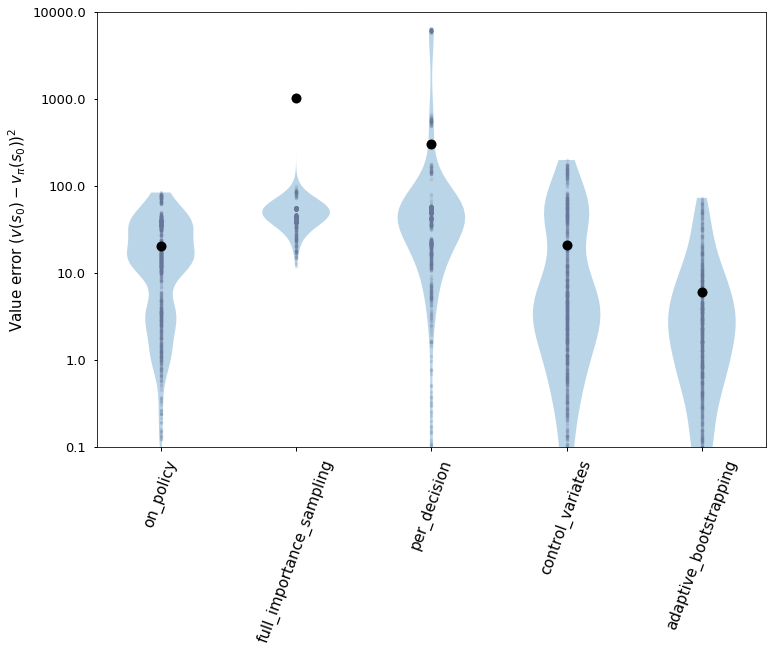

In [25]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision',
        'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)

print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 4.2 [5 marks]
Explain the ranking in terms of value error of the different return estimates.
> *Full important sampling has largest variance among four off policy methods. Since behaviour policy has probability of 0.5 of choosing right while 0.9 in target policy. The actions selected are due to a highly different policy.* 

> *In per decision method, variance is reduced and when one step importance sampling ratio rou = 0,  the return will be 0 and estimate will shrink. But when control variates part is added, it will keep the return as the estimate and the estimate unchanged. Besides, control variates won't change the expectation of return. Control variates make senses because when importance sampling ratio being zero the sample should be ignore and don't update on the estimate. Thus control variates has lower error mean.*

> *In adaptive bootstrapping, when rou > 1 the weight (1-lambda) of estimate at time t+1 decrease while weight (lambda) of G increase. When rou > 1, the action selected by behaviour policy is more frequently selected by target policy. It makes sense that we update more with this sample on the estimate when rou > 1. Thus adaptive bootstrapping perform best.*

> *In online policy learning, the action is selected from target policy. Though less exploration, it generally works well.*

### Q 4.3 [5 marks]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> *When we use function approximation with the best return above, we will meet problem of deadly Triad.*